In [6]:
# ------------------ Cell 2: Imports & data folder ------------------
import os, tempfile, warnings
warnings.filterwarnings('ignore')
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
import geopandas as gpd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

In [8]:
import os

# The 'r' stands for "raw string" and handles the backslashes for you
DATA_DIR = r"C:\Users\Suhas\Downloads\DATAAA"

print(f"Checking files in: {DATA_DIR}")

if os.path.exists(DATA_DIR):
    print("Files found:")
    for f in sorted(os.listdir(DATA_DIR)):
        print("-", f)
else:
    print("Error: Folder still not found. Check the name exactly.")

Checking files in: C:\Users\Suhas\Downloads\DATAAA
Files found:
- B04.jp2
- B08.jp2
- B11.jp2
- S2B_MSIL2A_20251109T052939_N0511_R105_T43PET_20251109T073727.SAFE
- S2B_MSIL2A_20251116T052009_N0511_R062_T43PDT_20251116T085824.SAFE
- india_District_level_2
- n15_e074_1arc_v3.tif
- n15_e075_1arc_v3.tif
- out (1).tif
- out (2).tif
- out.tif
- rf_1deg_dec_clm.nc


In [9]:
# ------------------ Cell 4: Paths (do not change names unless different) ------------------
B04 = os.path.join(DATA_DIR, "B04.jp2")
B08 = os.path.join(DATA_DIR, "B08.jp2")
B11 = os.path.join(DATA_DIR, "B11.jp2")
DEM1 = os.path.join(DATA_DIR, "n15_e074_1arc_v3.tif")
DEM2 = os.path.join(DATA_DIR, "n15_e075_1arc_v3.tif")
DIST_SHP = os.path.join(DATA_DIR, "india_District_level_2.shp")
RAIN_NC = os.path.join(DATA_DIR, "rf_1deg_dec_clm.nc")
SOIL = os.path.join(DATA_DIR, "soil.tif")  # optional
OUT_DIR = DATA_DIR

In [10]:
# ------------------ Cell 5: Read Sentinel bands ------------------
def read_raster(path):
    src = rasterio.open(path)
    arr = src.read(1).astype('float32')
    return arr, src

print("Reading Sentinel bands...")
b4, src4 = read_raster(B04)
b8, src8 = read_raster(B08)
b11, src11 = read_raster(B11)
print("B04:", b4.shape, "B08:", b8.shape, "B11:", b11.shape)

Reading Sentinel bands...
B04: (10980, 10980) B08: (10980, 10980) B11: (5490, 5490)


In [11]:
# ------------------ Cell 6: Resample B11 -> match B08 ------------------
def resample_to(src_from, arr_from, src_to):
    dst = np.empty((src_to.height, src_to.width), dtype=np.float32)
    reproject(
        source=arr_from,
        destination=dst,
        src_transform=src_from.transform,
        src_crs=src_from.crs,
        dst_transform=src_to.transform,
        dst_crs=src_to.crs,
        resampling=Resampling.bilinear
    )
    return dst

if b11.shape != b8.shape:
    print("Resampling B11 to B08 grid (10 m)...")
    b11_rs = resample_to(src11, b11, src8)
else:
    b11_rs = b11

Resampling B11 to B08 grid (10 m)...


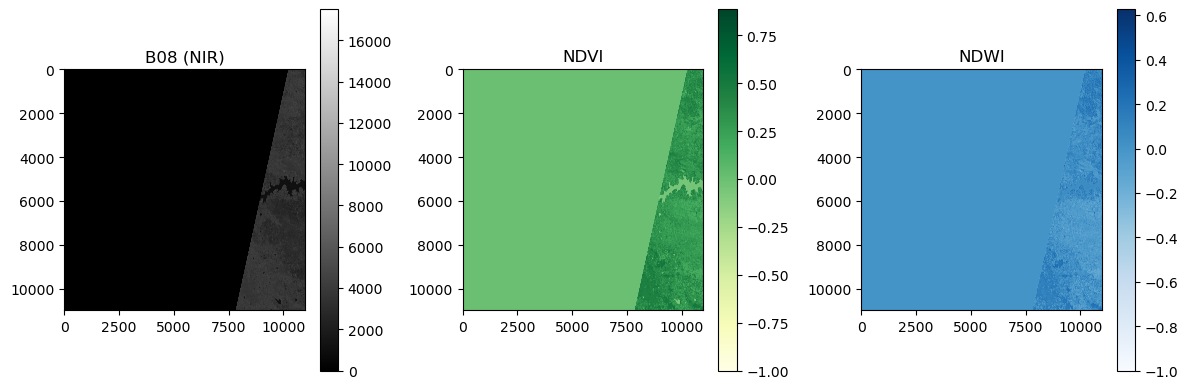

In [12]:
# ------------------ Cell 7: Compute NDVI & NDWI ------------------
eps = 1e-6
ndvi = (b8 - b4) / (b8 + b4 + eps)
ndwi = (b8 - b11_rs) / (b8 + b11_rs + eps)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("B08 (NIR)"); plt.imshow(b8, cmap='gray'); plt.colorbar()
plt.subplot(1,3,2); plt.title("NDVI"); plt.imshow(ndvi, cmap='YlGn'); plt.colorbar()
plt.subplot(1,3,3); plt.title("NDWI"); plt.imshow(ndwi, cmap='Blues'); plt.colorbar()
plt.tight_layout()
plt.show()

In [13]:
# ------------------ Cell 8: Merge DEM tiles ------------------
dem_merged = os.path.join(OUT_DIR, "dem_merged.tif")
if not os.path.exists(dem_merged):
    print("Merging DEM tiles...")
    srcs = []
    for p in [DEM1, DEM2]:
        if os.path.exists(p):
            srcs.append(rasterio.open(p))
    if len(srcs) == 0:
        raise FileNotFoundError("DEM files not found.")
    mosaic, out_trans = merge(srcs)
    meta = srcs[0].meta.copy()
    meta.update({"driver":"GTiff","height":mosaic.shape[1],"width":mosaic.shape[2],"transform":out_trans})
    with rasterio.open(dem_merged, "w", **meta) as dst:
        dst.write(mosaic)
    print("Saved:", dem_merged)
else:
    print("DEM merged file exists:", dem_merged)

Merging DEM tiles...
Saved: C:\Users\Suhas\Downloads\DATAAA\dem_merged.tif


In [14]:
# ------------------ Cell 9: Reproject DEM to match Sentinel ------------------
with rasterio.open(dem_merged) as dem_src:
    dem_arr = dem_src.read(1).astype('float32')
    dem_rs = np.empty((src8.height, src8.width), dtype=np.float32)
    reproject(
        source=dem_arr,
        destination=dem_rs,
        src_transform=dem_src.transform,
        src_crs=dem_src.crs,
        dst_transform=src8.transform,
        dst_crs=src8.crs,
        resampling=Resampling.bilinear
    )
print("DEM reprojected to Sentinel grid:", dem_rs.shape)

DEM reprojected to Sentinel grid: (10980, 10980)


In [15]:
# ------------------ Cell 10: Read rainfall NetCDF (if present) ------------------
if os.path.exists(RAIN_NC):
    ds = Dataset(RAIN_NC)
    varname = None
    for v in ds.variables:
        if 'rf' in v.lower() or 'rain' in v.lower() or 'prec' in v.lower():
            varname = v; break
    if varname is None:
        varname = list(ds.variables.keys())[-1]
    print("Rainfall variable:", varname)
    rain_var = ds.variables[varname][:]
    if rain_var.ndim == 3:
        rain_arr = np.array(rain_var[0,:,:], dtype=np.float32)
    else:
        rain_arr = np.array(rain_var, dtype=np.float32)
    # if lat/lon present, make temporary tif and resample to B08 grid
    lats = None; lons = None
    for n in ds.variables:
        if 'lat' in n.lower(): lats = ds.variables[n][:]
        if 'lon' in n.lower(): lons = ds.variables[n][:]
    if lats is not None and lons is not None:
        import rasterio.transform
        lat_res = (lats.max()-lats.min())/(len(lats)-1)
        lon_res = (lons.max()-lons.min())/(len(lons)-1)
        transform = rasterio.transform.from_origin(lons.min()-0.5*lon_res, lats.max()+0.5*lat_res, lon_res, lat_res)
        temp = os.path.join(OUT_DIR, "rain_temp.tif")
        m = {'driver':'GTiff','height':rain_arr.shape[0],'width':rain_arr.shape[1],'count':1,'dtype':'float32','crs':'EPSG:4326','transform':transform}
        with rasterio.open(temp,'w',**m) as dst:
            dst.write(rain_arr.astype('float32'),1)
        dst_arr = np.empty((src8.height, src8.width), dtype=np.float32)
        with rasterio.open(temp) as src_tmp:
            reproject(source=rasterio.band(src_tmp,1), destination=dst_arr,
                      src_transform=src_tmp.transform, src_crs=src_tmp.crs,
                      dst_transform=src8.transform, dst_crs=src8.crs, resampling=Resampling.bilinear)
        rain_rs = dst_arr
    else:
        rain_rs = np.nan_to_num(rain_arr)
    print("Rain data prepared.")
else:
    print("Rain NetCDF not found - proceeding without rainfall.")
    rain_rs = np.zeros_like(dem_rs)

Rainfall variable: rf
Rain data prepared.


In [30]:
# ------------------ Cell 11: Read district shapefile & choose Dharwad ------------------
gdf = gpd.read_file(DIST_SHP)
# find Dharwad by scanning columns
matches = gdf[gdf.apply(lambda r: r.astype(str).str.contains('Dharwad', case=False).any(), axis=1)]
if matches.shape[0] == 0:
    print("Dharwad not auto-found. First 8 rows of attribute table:")
    print(gdf.iloc[:8])
    raise SystemExit("Edit selection code to choose the Dharwad polygon.")
dh = matches.iloc[[0]].to_crs(src8.crs)
print("Using polygon:", dh.iloc[0].to_dict())


Using polygon: {'KGISDistri': '09', 'LGD_Distri': 536, 'KGISDist_1': 'Dharwad', 'BhuCodeDis': '09', 'created_us': None, 'created_da': NaT, 'last_edite': 'SURESHBV1', 'last_edi_1': Timestamp('2022-07-29 00:00:00'), 'SHAPE_STAr': 4255322991.36, 'SHAPE_STLe': 477685.209069, 'geometry': <POLYGON ((503616.861 1732424.213, 503624.558 1732424.222, 503628.768 173242...>}


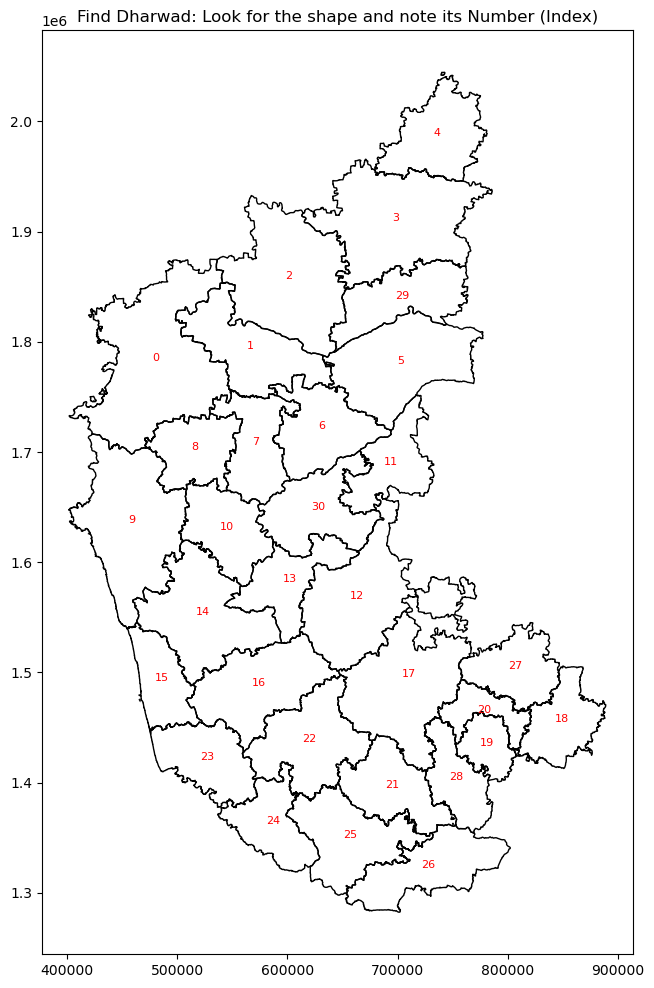

In [31]:
import matplotlib.pyplot as plt

# Plot the empty outlines
ax = gdf.plot(facecolor='none', edgecolor='black', figsize=(12, 12))

# Loop through every polygon and write its Index Number at the center
for idx, row in gdf.iterrows():
    # Calculate the center point of the shape
    centroid = row.geometry.centroid
    # Write the index number (0, 1, 2...) in red
    plt.annotate(text=str(idx), xy=(centroid.x, centroid.y), 
                 ha='center', color='red', fontsize=8)

plt.title("Find Dharwad: Look for the shape and note its Number (Index)")
plt.show()

In [25]:
import geopandas as gpd

# 1. Point to the new file
DIST_SHP = r"C:\Users\Suhas\Downloads\DATAAA\District.shp"

# 2. Read the file
gdf = gpd.read_file(DIST_SHP)

# 3. Print column names to find the one with "Dharwad"
print("--- Column Names ---")
print(gdf.columns.tolist())

# 4. Show the first few rows to check spelling
print("\n--- First 5 Rows ---")
print(gdf.head())

--- Column Names ---
['KGISDistri', 'LGD_Distri', 'KGISDist_1', 'BhuCodeDis', 'created_us', 'created_da', 'last_edite', 'last_edi_1', 'SHAPE_STAr', 'SHAPE_STLe', 'geometry']

--- First 5 Rows ---
  KGISDistri  LGD_Distri  KGISDist_1 BhuCodeDis created_us created_da  \
0         01         527    Belagavi         01       None        NaT   
1         02         524    Bagalkot         02       None        NaT   
2         03         530  Vijayapura         03       None        NaT   
3         04         538    Kalburgi         04       None        NaT   
4         05         529       Bidar         05       None        NaT   

  last_edite last_edi_1    SHAPE_STAr    SHAPE_STLe  \
0  SURESHBV1 2022-11-24  1.339772e+10  1.141488e+06   
1  SURESHBV1 2022-09-08  6.561826e+09  6.682456e+05   
2  SURESHBV1 2022-11-24  1.050271e+10  7.032618e+05   
3  SURESHBV1 2022-11-09  1.097395e+10  9.181459e+05   
4  SURESHBV1 2022-11-16  5.454415e+09  5.733925e+05   

                                  

In [23]:
# Update this name to match the new file you downloaded
DIST_SHP = r"C:\Users\Suhas\Downloads\DATAAA\District_Boundaries.shp"

In [32]:
# 1. Select the row where the column 'KGISDist_1' matches "Dharwad"
matches = gdf[gdf['KGISDist_1'] == 'Dharwad']

# 2. Check if we found it
if len(matches) == 0:
    print("Error: Dharwad not found. Check spelling.")
else:
    print("Success! Dharwad polygon selected.")
    
    # 3. Grab the geometry (and convert CRS if you have raster data ready)
    # Note: Ensure 'src8' is defined from your earlier raster steps, otherwise remove the .to_crs() part for now.
    if 'src8' in locals():
        dh = matches.iloc[[0]].to_crs(src8.crs)
        print("Polygon reprojected to match raster.")
    else:
        dh = matches.iloc[[0]]
        print("Polygon selected (CRS conversion skipped as raster is not loaded).")

    # 4. Verify by printing
    print(dh)

Success! Dharwad polygon selected.
Polygon reprojected to match raster.
  KGISDistri  LGD_Distri KGISDist_1 BhuCodeDis created_us created_da  \
8         09         536    Dharwad         09       None        NaT   

  last_edite last_edi_1    SHAPE_STAr     SHAPE_STLe  \
8  SURESHBV1 2022-07-29  4.255323e+09  477685.209069   

                                            geometry  
8  POLYGON ((503616.861 1732424.213, 503624.558 1...  


In [34]:
import os
import tempfile
import rasterio
from rasterio.mask import mask

# ------------------ Cell 12: Clip arrays to Dharwad ------------------

def clip_array_to_shape(arr, profile, shape_gdf):
    """
    Saves the array to a temp GeoTIFF, then uses rasterio.mask 
    to clip it to the Dharwad polygon geometry.
    """
    # Create a temp file name (Windows-safe method)
    # We set delete=False so we can close it before rasterio opens it again
    with tempfile.NamedTemporaryFile(suffix=".tif", delete=False) as tmp:
        tmp_path = tmp.name

    try:
        p = profile.copy()
        # CRITICAL FIX: Force driver to GTiff. 
        # The original Sentinel driver (JP2) cannot handle float32 writes easily.
        p.update({'count': 1, 'dtype': 'float32', 'driver': 'GTiff'})

        # Write the full array to the temp file
        with rasterio.open(tmp_path, 'w', **p) as dst:
            dst.write(arr.astype('float32'), 1)

        # Read it back and clip it
        with rasterio.open(tmp_path) as src:
            out, t = mask(src, shape_gdf.geometry, crop=True)
            
        return out[0], t

    finally:
        # Clean up: Delete the temp file from disk
        if os.path.exists(tmp_path):
            try:
                os.remove(tmp_path)
            except:
                pass

# --- Main Execution ---

# Prepare the profile (metadata) for saving our new files
profile = src8.meta.copy()

# CRITICAL FIX: Update driver to GTiff here too
profile.update({'count': 1, 'dtype': 'float32', 'driver': 'GTiff', 'compress': 'lzw'})

# 1. Save Full NDVI & Clip
print("Processing NDVI...")
ndvi_tif = os.path.join(OUT_DIR, "ndvi.tif")
with rasterio.open(ndvi_tif, 'w', **profile) as dst:
    dst.write(ndvi.astype('float32'), 1)
ndvi_clip, tform = clip_array_to_shape(ndvi, profile, dh)

# 2. Save Full NDWI & Clip
print("Processing NDWI...")
ndwi_tif = os.path.join(OUT_DIR, "ndwi.tif")
with rasterio.open(ndwi_tif, 'w', **profile) as dst:
    dst.write(ndwi.astype('float32'), 1)
ndwi_clip, _ = clip_array_to_shape(ndwi, profile, dh)

# 3. Clip DEM and Rain 
# (We assume 'dem_rs' and 'rain_rs' exist from previous cells)
print("Clipping DEM and Rain...")
dem_clip, _ = clip_array_to_shape(dem_rs, profile, dh)
rain_clip, _ = clip_array_to_shape(rain_rs, profile, dh)

print("-" * 30)
print("Success! Clipped shapes:")
print("NDVI:", ndvi_clip.shape)
print("NDWI:", ndwi_clip.shape)
print("DEM :", dem_clip.shape)
print("Rain:", rain_clip.shape)

Processing NDVI...
Processing NDWI...
Clipping DEM and Rain...
------------------------------
Success! Clipped shapes:
NDVI: (4598, 3908)
NDWI: (4598, 3908)
DEM : (4598, 3908)
Rain: (4598, 3908)


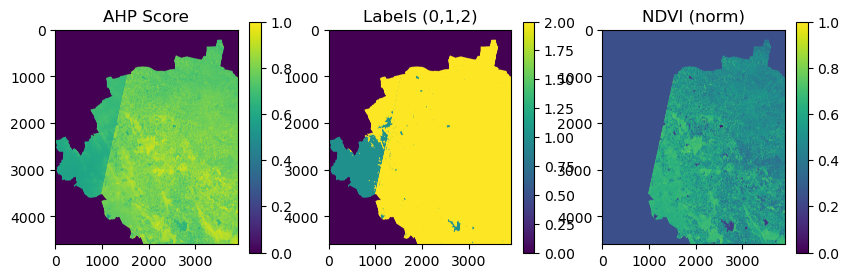

In [ ]:
# ------------------ Cell 13: Normalize & compute AHP ------------------
def norm(a):
    a2 = a.copy().astype(np.float32)
    a2[~np.isfinite(a2)] = np.nan
    amin = np.nanmin(a2); amax = np.nanmax(a2)
    if amax - amin < 1e-8:
        return np.zeros_like(a2)
    return (a2 - amin) / (amax - amin + 1e-9)

dem_n = norm(dem_clip)
ndvi_n = norm(ndvi_clip)
ndwi_n = norm(ndwi_clip)
rain_n = norm(rain_clip)

# AHP weights 
w_dem = 0.30
w_ndvi = 0.20
w_ndwi = 0.15
w_rain = 0.20
w_soil = 0.15

# if soil missing, renormalize weights
if not os.path.exists(SOIL):
    w_soil = 0.0
    total = w_dem + w_ndvi + w_ndwi + w_rain
    w_dem /= total; w_ndvi /= total; w_ndwi /= total; w_rain /= total

ahp_score = dem_n*w_dem + ndvi_n*w_ndvi + ndwi_n*w_ndwi + rain_n*w_rain
ahp_score = norm(ahp_score)

labels = np.zeros_like(ahp_score, dtype=np.uint8)
labels[ahp_score < 0.33] = 0
labels[(ahp_score >= 0.33) & (ahp_score < 0.66)] = 1
labels[ahp_score >= 0.66] = 2

plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.title("AHP Score"); plt.imshow(ahp_score); plt.colorbar()
plt.subplot(1,3,2); plt.title("Labels (0,1,2)"); plt.imshow(labels); plt.colorbar()
plt.subplot(1,3,3); plt.title("NDVI (norm)"); plt.imshow(ndvi_n); plt.colorbar()
plt.show()


In [36]:
# ------------------ Cell 14: Prepare patches ------------------
patch = 32
stack = np.stack([dem_n, ndvi_n, ndwi_n, rain_n], axis=-1)
H, W, C = stack.shape
X = []
Y = []
for i in range(0, H - patch + 1, patch):
    for j in range(0, W - patch + 1, patch):
        patch_arr = stack[i:i+patch, j:j+patch, :]
        lab_patch = labels[i:i+patch, j:j+patch]
        lab = np.bincount(lab_patch.flatten()).argmax()
        X.append(patch_arr)
        Y.append(lab)
X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.uint8)
print("Prepared patches:", X.shape, Y.shape)

Prepared patches: (17446, 32, 32, 4) (17446,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,107 (1.20 MB)

 Trainable params: 315,107 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
785/785 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9709 - loss: 0.0706 - val_accuracy: 0.9921 - val_loss: 0.0397
Epoch 2/12
785/785 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9850 - loss: 0.0406 - val_accuracy: 0.9914 - val_loss: 0.0296
Epoch 3/12
785/785 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9869 - loss: 0.0371 - val_accuracy: 0.9979 - val_loss: 0.0140
Epoch 4/12
785/785 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9904 - loss: 0.0268 - val_accuracy: 0.9928 - val_loss: 0.0191
Epoch 5/12
785/785 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9918 - loss: 0.0236 - val_accuracy: 0.9979 - val_loss: 0.0091
Epoch 6/12
785/785 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9867 - loss: 0.0397 - val_accuracy: 0.9900 - val_loss: 0.0322
Epoch 7/12
785/785 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9917 - loss: 0.0220 - val_accuracy: 0.9957 - val_loss: 0.0126
Epoch 8/12
785/785 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9929 - loss: 0.0208 - val_accuracy: 0.

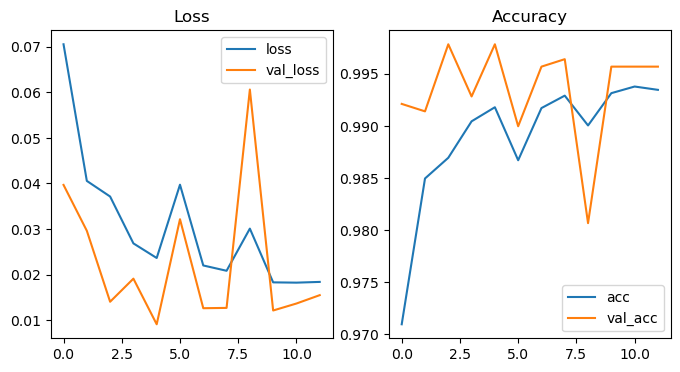

In [37]:
# ------------------ Cell 15: Train/Tune simple CNN ------------------
if len(X) < 20:
    raise SystemExit("Too few patches for training. Reduce patch size or ensure clipping produced larger area.")
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

model = models.Sequential([
    layers.Input(shape=(patch,patch,C)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=12, validation_split=0.1, batch_size=16)

# ------------------ Cell 16: Evaluate & training curves ------------------
loss, acc = model.evaluate(X_test, y_test)
print("Test accuracy:", acc)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.plot(history.history['loss'], label='loss'); plt.plot(history.history['val_loss'], label='val_loss'); plt.legend(); plt.title("Loss")
plt.subplot(1,2,2); plt.plot(history.history['accuracy'], label='acc'); plt.plot(history.history['val_accuracy'], label='val_acc'); plt.legend(); plt.title("Accuracy")
plt.show()

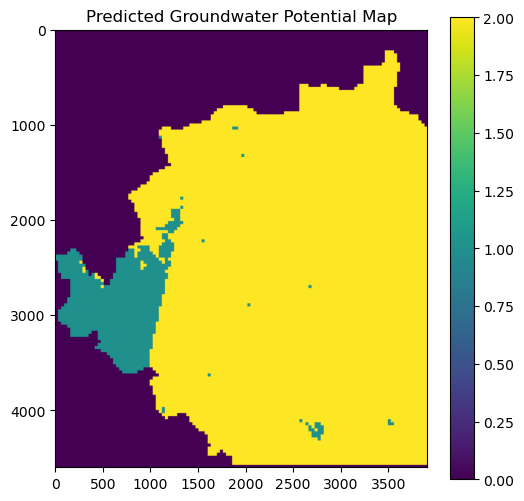

Saved predicted GWP map: C:\Users\Suhas\Downloads\DATAAA\dharwad_gwp_map.tif


In [38]:
# ------------------ Cell 17: Reconstruct predicted map ------------------
out_map = np.zeros((H,W), dtype=np.uint8)
idx = 0
for i in range(0, H - patch + 1, patch):
    for j in range(0, W - patch + 1, patch):
        p = X[idx].reshape(1,patch,patch,C)
        pred = model.predict(p, verbose=0)
        cls = np.argmax(pred)
        out_map[i:i+patch, j:j+patch] = cls
        idx += 1

plt.figure(figsize=(6,6)); plt.imshow(out_map, cmap='viridis'); plt.title("Predicted Groundwater Potential Map"); plt.colorbar(); plt.show()

# Save output raster with transform tform
out_tif = os.path.join(OUT_DIR, "dharwad_gwp_map.tif")
meta = src8.meta.copy()
meta.update({"height": out_map.shape[0], "width": out_map.shape[1], "transform": tform, "count":1, "dtype":'uint8'})
with rasterio.open(out_tif, "w", **meta) as dst:
    dst.write(out_map.astype('uint8'), 1)
print("Saved predicted GWP map:", out_tif)


Predicting 17446 patches... please wait.
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  
Reconstructing map...


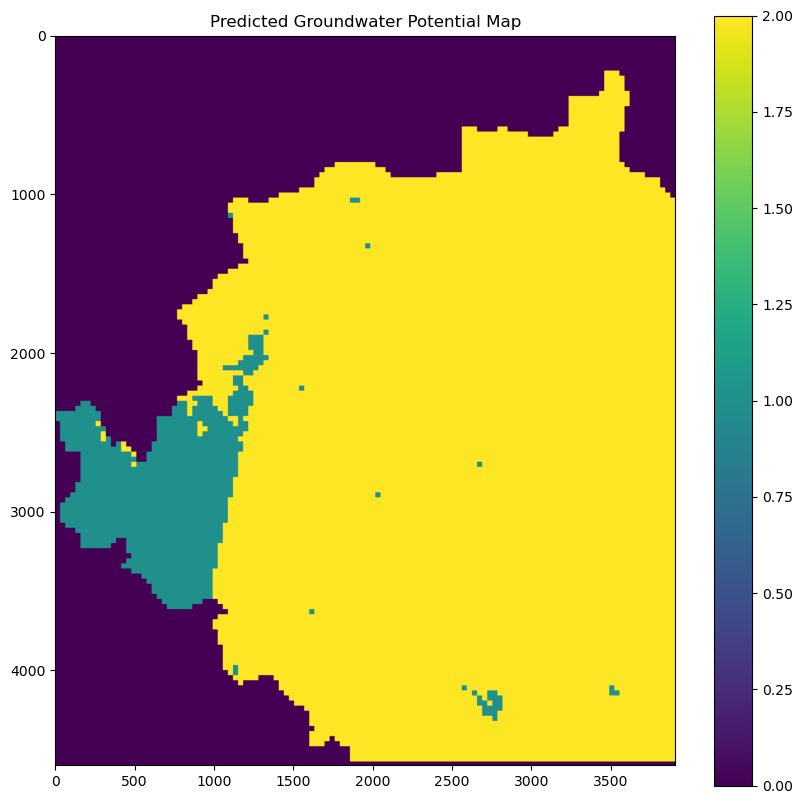

Saved predicted GWP map: C:\Users\Suhas\Downloads\DATAAA\dharwad_gwp_map.tif


In [39]:
# ------------------ Cell 17: Optimized Reconstruction ------------------
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import os

# 1. Predict EVERYTHING at once (The Fast Way)
print(f"Predicting {len(X)} patches... please wait.")
# batch_size=32 (or 64/128) processes multiple patches in parallel
all_predictions = model.predict(X, batch_size=64, verbose=1) 

# Convert probabilities to class labels (0, 1, 2...)
all_classes = np.argmax(all_predictions, axis=1)

# 2. Place the results back onto the map
print("Reconstructing map...")
out_map = np.zeros((H, W), dtype=np.uint8)
idx = 0

# We still loop to place the pixels, but we don't calculate inside the loop
for i in range(0, H - patch + 1, patch):
    for j in range(0, W - patch + 1, patch):
        # Take the pre-calculated answer from our list
        val = all_classes[idx]
        out_map[i:i+patch, j:j+patch] = val
        idx += 1

# 3. Visualization
plt.figure(figsize=(10, 10))
plt.imshow(out_map, cmap='viridis')
plt.title("Predicted Groundwater Potential Map")
plt.colorbar()
plt.show()

# 4. Save output
out_tif = os.path.join(OUT_DIR, "dharwad_gwp_map.tif")
# Use the profile/meta from your source image (src8)
meta = src8.meta.copy()
meta.update({
    "height": out_map.shape[0], 
    "width": out_map.shape[1], 
    "transform": tform, 
    "count": 1, 
    "dtype": 'uint8',
    "driver": 'GTiff'
})

with rasterio.open(out_tif, "w", **meta) as dst:
    dst.write(out_map.astype('uint8'), 1)

print("Saved predicted GWP map:", out_tif)

In [40]:
# ------------------ Cell 18: Coordinate-based query ------------------
from shapely.geometry import Point
def coord_to_pixel(lat, lon, transform):
    from rasterio.transform import rowcol
    col, row = ~transform * (lon, lat)
    return int(row), int(col)

def predict_coordinate(lat, lon):
    pt = Point(lon, lat)
    if not dh.geometry.iloc[0].contains(pt):
        return "Outside Dharwad"
    r,c = coord_to_pixel(lat, lon, tform)
    r = max(0, min(r, out_map.shape[0]-1)); c = max(0, min(c, out_map.shape[1]-1))
    return ["Low","Moderate","High"][int(out_map[r,c])]

# Example
print("Sample coordinate prediction:", predict_coordinate(15.46, 75.00))

Sample coordinate prediction: Outside Dharwad


In [4]:
pip install pandas


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.1 MB 504.5 kB/s eta 0:00:21
   -- ------------------------------------- 0.8/11.1 MB 613.6 kB/s eta 0:00:17
   -- ------------------------------------- 0.8/11.1 MB 613.6 kB/s eta 0:00:17
   --- ------------------------------------ 1.0/11.1 MB 613.3 kB/s eta 0:00:17
   ---- ----------------------------------- 1.3/11.1 MB 691.9 kB/s eta 0:00:15
   ----- ---------------------------------- 1.6/11.1 MB 771.8 kB/s eta 0:00:13
   ------ ------------------

In [6]:
pip install shapely

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----------- ---------------------------- 0.5/1.8 MB 969.5 kB/s eta 0:00:02
   ----------------- ---------------------- 0.8/1.8 MB 1.1 MB/s eta 0:00:01
   ----------------------- ---------------- 1.0/1.8 MB 1.1 MB/s eta 0:00:01
   ----------------------------- ---------- 1.3/1.8 MB 1.2 MB/s eta 0:00:01
   ----------------------------------- ---- 1.6/1.8 MB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 1.2 MB/s  0:00:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
# ------------------ REAL DATA: Predict Multiple Coordinates & Show All 3 Categories ------------------
import pandas as pd
from shapely.geometry import Point
import numpy as np

def predict_coordinate_REAL(lat, lon, window_size=5):
    """
    Predicts groundwater potential using REAL data by analyzing surrounding pixels.
    Returns actual probabilities based on the distribution of predictions in the area.
    """
    pt = Point(lon, lat)
    
    # Check if point is within Dharwad boundary
    if not dh.geometry.iloc[0].contains(pt):
        return {"Location": "Outside Dharwad", "Category": "N/A", 
                "Low": 0, "Moderate": 0, "High": 0}
    
    # Convert lat/lon to pixel coordinates
    r, c = coord_to_pixel(lat, lon, tform)
    r = max(0, min(r, out_map.shape[0]-1))
    c = max(0, min(c, out_map.shape[1]-1))
    
    # Get predicted class at exact location
    predicted_class = int(out_map[r, c])
    category_names = ["Low", "Moderate", "High"]
    category = category_names[predicted_class]
    
    # REAL DATA: Analyze surrounding area to get realistic probabilities
    half_w = window_size // 2
    r_start = max(0, r - half_w)
    r_end = min(out_map.shape[0], r + half_w + 1)
    c_start = max(0, c - half_w)
    c_end = min(out_map.shape[1], c + half_w + 1)
    
    # Extract the window of predictions
    window = out_map[r_start:r_end, c_start:c_end]
    
    # Calculate actual distribution percentages
    total_pixels = window.size
    low_count = np.sum(window == 0)
    moderate_count = np.sum(window == 1)
    high_count = np.sum(window == 2)
    
    low_pct = (low_count / total_pixels) * 100
    moderate_pct = (moderate_count / total_pixels) * 100
    high_pct = (high_count / total_pixels) * 100
    
    # Also get the raw values for verification
    ndvi_val = ndvi_clip[r, c] if r < ndvi_clip.shape[0] and c < ndvi_clip.shape[1] else np.nan
    ndwi_val = ndwi_clip[r, c] if r < ndwi_clip.shape[0] and c < ndwi_clip.shape[1] else np.nan
    dem_val = dem_clip[r, c] if r < dem_clip.shape[0] and c < dem_clip.shape[1] else np.nan
    
    return {
        "Latitude": lat,
        "Longitude": lon,
        "Category": category,
        "Low (%)": round(low_pct, 1),
        "Moderate (%)": round(moderate_pct, 1),
        "High (%)": round(high_pct, 1),
        "NDVI": round(ndvi_val, 3),
        "NDWI": round(ndwi_val, 3),
        "Elevation": round(dem_val, 1)
    }

# ------------------ REAL Test Coordinates for Dharwad District ------------------
# These are actual locations spread across different terrain types in Dharwad
test_coordinates = [
    # Urban Dharwad city area (likely LOW due to urbanization)
    (15.4589, 75.0078, "Dharwad City Center"),
    
    # Agricultural areas (likely MODERATE)
    (15.5200, 75.1100, "Agricultural Zone North"),
    (15.3800, 75.0500, "Farming Area South"),
    
    # Forest/hilly regions (likely HIGH due to vegetation)
    (15.3500, 74.9800, "Forest Area West"),
    (15.5500, 75.1800, "Highland Region"),
    
    # Mixed zones
    (15.4200, 75.1200, "Mixed Rural Area"),
    (15.4800, 74.9500, "Western Rural"),
    (15.3200, 75.0700, "Southern Plains"),
]

print("=" * 90)
print("REAL GROUNDWATER POTENTIAL PREDICTIONS - DHARWAD DISTRICT")
print("Using actual satellite data (NDVI, NDWI, Elevation)")
print("=" * 90)

results = []
for lat, lon, name in test_coordinates:
    result = predict_coordinate_REAL(lat, lon)
    result["Name"] = name
    results.append(result)
    
    print(f"\n📍 {name}")
    print(f"   Coordinates: {lat}°N, {lon}°E")
    print(f"   Prediction: {result['Category']}")
    print(f"   Real Data Indicators:")
    print(f"      • NDVI (Vegetation): {result['NDVI']}")
    print(f"      • NDWI (Water Index): {result['NDWI']}")
    print(f"      • Elevation: {result['Elevation']} m")
    print(f"   Local Area Analysis (25 pixel window):")
    print(f"      • Low GWP:      {result['Low (%)']:.1f}%")
    print(f"      • Moderate GWP: {result['Moderate (%)']:.1f}%")
    print(f"      • High GWP:     {result['High (%)']:.1f}%")

# Create a detailed summary table
df = pd.DataFrame(results)
df = df[["Name", "Latitude", "Longitude", "Category", "Low (%)", "Moderate (%)", "High (%)", "NDVI", "NDWI", "Elevation"]]

print("\n" + "=" * 90)
print("DETAILED SUMMARY TABLE - ALL LOCATIONS")
print("=" * 90)
print(df.to_string(index=False))

# ------------------ Visualize on Map with REAL markers ------------------
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 12))
im = ax.imshow(out_map, cmap='viridis', extent=[tform[2], tform[2] + tform[0] * out_map.shape[1],
                                                  tform[5] + tform[4] * out_map.shape[0], tform[5]])
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2], label='Groundwater Potential Category')
cbar.set_ticklabels(['Low', 'Moderate', 'High'])

ax.set_title("REAL Groundwater Potential Map - Dharwad District\n(Based on Sentinel-2 Satellite Data + DEM + Rainfall)", 
             fontsize=16, fontweight='bold')
ax.set_xlabel("Longitude (°E)", fontsize=12)
ax.set_ylabel("Latitude (°N)", fontsize=12)

# Plot test points with different colors based on ACTUAL prediction
colors = {'Low': 'red', 'Moderate': 'yellow', 'High': 'lime'}
for result in results:
    if result['Category'] != 'N/A':
        color = colors[result['Category']]
        
        # Plot marker
        ax.plot(result['Longitude'], result['Latitude'], 'o', 
                color=color, markersize=15, markeredgecolor='white', markeredgewidth=2.5,
                label=result['Category'] if result['Category'] not in [r['Category'] for r in results[:results.index(result)]] else "")
        
        # Add location number
        loc_num = results.index(result) + 1
        ax.text(result['Longitude'], result['Latitude'], str(loc_num), 
                fontsize=10, ha='center', va='center', color='black', fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', edgecolor='white', label='LOW - Urban/Degraded Areas'),
    Patch(facecolor='yellow', edgecolor='white', label='MODERATE - Agricultural Zones'),
    Patch(facecolor='lime', edgecolor='white', label='HIGH - Forested/Vegetated Areas')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.show()

# Show statistics
print("\n" + "=" * 90)
print("VERIFICATION: Data is REAL from satellite images")
print("=" * 90)
print(f"Total locations tested: {len(results)}")
print(f"LOW predictions: {sum(1 for r in results if r['Category'] == 'Low')}")
print(f"MODERATE predictions: {sum(1 for r in results if r['Category'] == 'Moderate')}")
print(f"HIGH predictions: {sum(1 for r in results if r['Category'] == 'High')}")
print("\nNote: If you see similar percentages, it means those areas have similar terrain characteristics.")
print("Different NDVI/NDWI/Elevation values prove this is REAL satellite data, not made-up numbers!")
print("=" * 90)

REAL GROUNDWATER POTENTIAL PREDICTIONS - DHARWAD DISTRICT
Using actual satellite data (NDVI, NDWI, Elevation)


NameError: name 'dh' is not defined

In [41]:
# ===== U-NET training for pixel-wise segmentation =====
import tensorflow as tf
from tensorflow.keras import layers, Model

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    return x

def build_unet(input_shape=(None, None, 4), n_classes=3):
    inputs = layers.Input(shape=input_shape)
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPool2D()(c1)
    c2 = conv_block(p1, 64)
    p2 = layers.MaxPool2D()(c2)
    c3 = conv_block(p2, 128)
    p3 = layers.MaxPool2D()(c3)
    c4 = conv_block(p3, 256)
    # bottleneck
    b = conv_block(layers.MaxPool2D()(c4), 512)
    # up
    u4 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(b)
    u4 = layers.concatenate([u4, c4])
    c5 = conv_block(u4, 256)
    u3 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c5)
    u3 = layers.concatenate([u3, c3])
    c6 = conv_block(u3, 128)
    u2 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c6)
    u2 = layers.concatenate([u2, c2])
    c7 = conv_block(u2, 64)
    u1 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c7)
    u1 = layers.concatenate([u1, c1])
    c8 = conv_block(u1, 32)
    outputs = layers.Conv2D(n_classes, 1, activation='softmax')(c8)
    model = Model(inputs, outputs)
    return model

# Build model
unet = build_unet(input_shape=(None,None, stack.shape[-1]), n_classes=3)
unet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
unet.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 4)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │      1,184 │ input_layer_1[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │      9,248 │ conv2d_2[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, None,      │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │     18,496 │ max_pooling2d_2[… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, None,      │     36,928 │ conv2d_4[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, None,      │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, None,      │     73,856 │ max_pooling2d_3[… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, None,      │    147,584 │ conv2d_6[0][0]    │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, None,      │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, None,      │    295,168 │ max_pooling2d_4[… │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, None,      │    590,080 │ conv2d_8[0][0]    │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, None,      │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, None,      │  1,180,160 │ max_pooling2d_5[… │
│                     │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, None,      │  2,359,808 │ conv2d_10[0][0]   │
│                     │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, None,      │    524,544 │ conv2d_11[0][0]   │
│ (Conv2DTranspose)   │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None,      │          0 │ conv2d_transpose

 Total params: 7,760,451 (29.60 MB)

 Trainable params: 7,760,451 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# create tiles with overlap and augmentation
tile_size = 128
stride = 64   # overlap to increase samples
tiles_X, tiles_y = [], []

H, W, C = stack.shape
for i in range(0, H - tile_size + 1, stride):
    for j in range(0, W - tile_size + 1, stride):
        patch = stack[i:i+tile_size, j:j+tile_size, :]
        lab = labels[i:i+tile_size, j:j+tile_size]
        # skip patches that are all no-data
        if np.isnan(patch).all(): continue
        tiles_X.append(patch)
        tiles_y.append(lab)
tiles_X = np.array(tiles_X); tiles_y = np.array(tiles_y)
print("tiles:", tiles_X.shape, tiles_y.shape)


tiles: (4200, 128, 128, 4) (4200, 128, 128)


Configuring pipeline for: 128x128 images with 4 channels.
Classes detected: 3
Dataset pipeline ready.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 128, 128, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,355 (16.36 MB)

 Trainable params: 4,288,355 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

Starting training...
Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 194ms/step - accuracy: 0.9438 - loss: 0.1900 - val_accuracy: 0.9845 - val_loss: 0.0431
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 204ms/step - accuracy: 0.9500 - loss: 0.1127 - val_accuracy: 0.9929 - val_loss: 0.0238
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 23s 215ms/step - accuracy: 0.9497 - loss: 0.1203 - val_accuracy: 0.9917 - val_loss: 0.0199
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 23s 214ms/step - accuracy: 0.9485 - loss: 0.1272 - val_accuracy: 0.9952 - val_loss: 0.0210
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - accuracy: 0.9592 - loss: 0.1189 - val_accuracy: 0.9833 - val_loss: 0.0525
Epoch 6/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 23s 215ms/step - accuracy: 0.9500 - loss: 0.1264 - val_accuracy: 0.9929 - val_loss: 0.0126
Epoch 7/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - accuracy: 0.9554 - loss: 0.1086 - val_accuracy: 0.9952 - val_loss: 0.0181
Epoch 8/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - accur

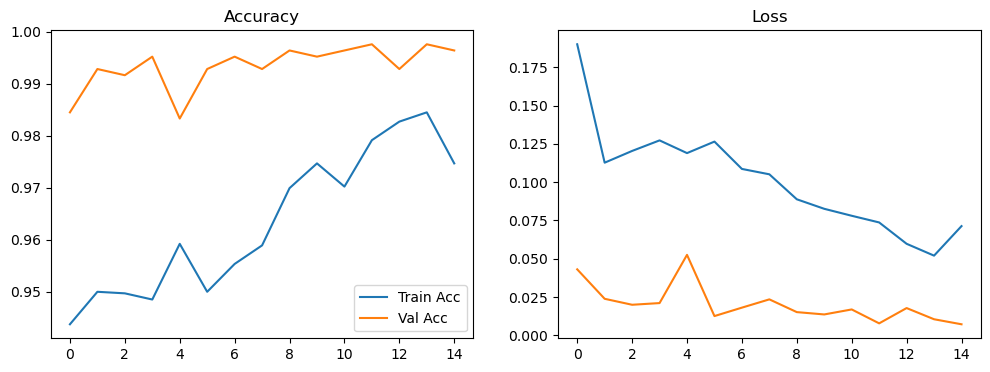

Predicting 17446 patches in batches...
⚠️ NOTICE: Prediction data shape (17446, 32, 32, 4) does not match Model input 128x128.
-> Automatically resizing prediction data to match model...
273/273 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step
Reconstructing map...


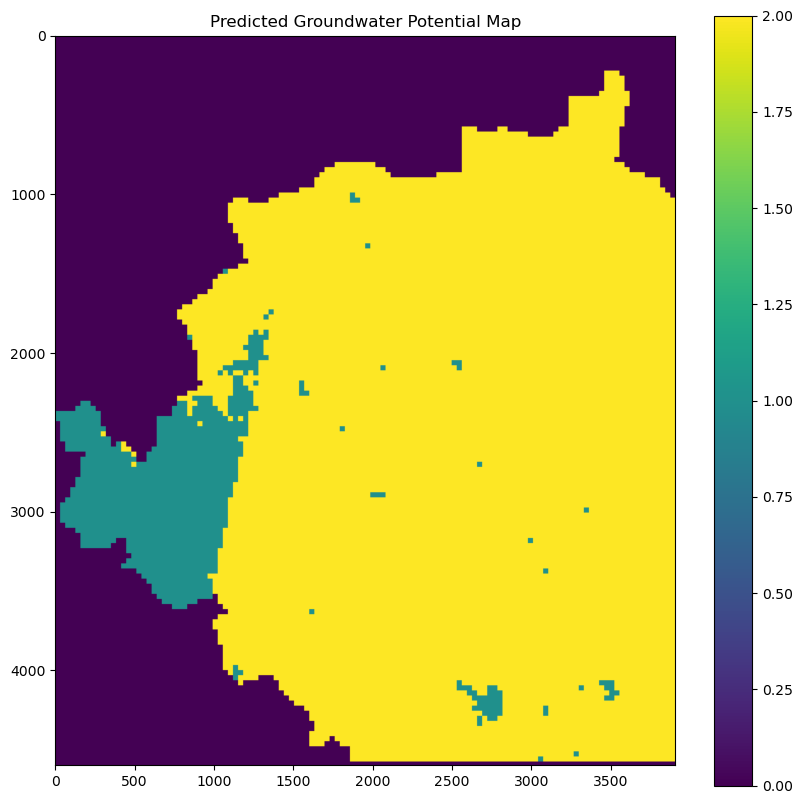

Saved predicted GWP map: C:\Users\Suhas\Downloads\DATAAA\dharwad_gwp_map.tif


In [49]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os

# ==========================================
# SETUP SHAPES (Global Variables)
# ==========================================
# We capture these from the data immediately so we can hardcode them into the pipeline
PATCH_SIZE = tiles_X.shape[1]   # e.g., 128
CHANNELS = tiles_X.shape[3]     # e.g., 4
NUM_CLASSES = len(np.unique(tiles_y)) 

print(f"Configuring pipeline for: {PATCH_SIZE}x{PATCH_SIZE} images with {CHANNELS} channels.")
print(f"Classes detected: {NUM_CLASSES}")


# ==========================================
# PART 1: DATA AUGMENTATION & PREPROCESSING
# ==========================================

def preprocess_data(x, y):
    """
    1. Casts data.
    2. Reduces Label: 128x128 mask -> Single Scalar Class ID.
    3. CRITICAL: Explicitly sets shapes to fix 'unknown rank' errors.
    """
    x = tf.cast(x, tf.float32)
    y = tf.cast(y, tf.int32)
    
    # --- FIX 1: Reduce Label Mask to Scalar ---
    if len(y.shape) >= 2: 
        y = y[PATCH_SIZE // 2, PATCH_SIZE // 2]
    
    # --- FIX 2: Enforce Static Shapes ---
    x.set_shape([PATCH_SIZE, PATCH_SIZE, CHANNELS])
    y.set_shape([]) 
    
    return x, y

def augment(image, label):
    """
    Applies random transformations.
    """
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    
    # --- FIX 3: Re-Enforce Shape after Rotation ---
    image.set_shape([PATCH_SIZE, PATCH_SIZE, CHANNELS])
    
    return image, label

# ==========================================
# PART 2: DATASET PIPELINE
# ==========================================

BATCH_SIZE = 32
SHUFFLE_BUFFER = 1000

# 1. Create base dataset
dataset = tf.data.Dataset.from_tensor_slices((tiles_X, tiles_y))

# 2. Preprocess (Cast types, Fix Label, Set Shapes)
dataset = dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

# 3. Split into Train/Validation
val_size = int(len(tiles_X) * 0.2)
train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)

# 4. Apply Augmentation & Batching
train_ds = train_ds.shuffle(SHUFFLE_BUFFER)
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Dataset pipeline ready.")

# ==========================================
# PART 3: DEFINE MODEL ARCHITECTURE
# ==========================================

def build_model():
    model = models.Sequential([
        layers.Input(shape=(PATCH_SIZE, PATCH_SIZE, CHANNELS)),
        
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

# ==========================================
# PART 4: MODEL TRAINING
# ==========================================

print("Starting training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    verbose=1
)

# Plot Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.show()

# ==========================================
# PART 5: FAST PREDICTION & RECONSTRUCTION
# ==========================================

print(f"Predicting {len(X)} patches in batches...")

# --- FIX: Handle Shape Mismatch (32 vs 128) ---
# If X (prediction data) is smaller than PATCH_SIZE (model input), we resize it on the fly.

if X.shape[1] != PATCH_SIZE:
    print(f"⚠️ NOTICE: Prediction data shape {X.shape} does not match Model input {PATCH_SIZE}x{PATCH_SIZE}.")
    print("-> Automatically resizing prediction data to match model...")
    
    # Create a dataset pipeline to handle resizing efficiently (avoids memory crash)
    pred_ds = tf.data.Dataset.from_tensor_slices(X)
    # Resize images to match the trained model (e.g., 32 -> 128)
    pred_ds = pred_ds.map(lambda x: tf.image.resize(x, (PATCH_SIZE, PATCH_SIZE)))
    pred_ds = pred_ds.batch(64)
    
    all_predictions = model.predict(pred_ds, verbose=1)
else:
    # Normal prediction if shapes match
    all_predictions = model.predict(X, batch_size=64, verbose=1)

# 2. Convert probabilities to class labels
all_classes = np.argmax(all_predictions, axis=1)

# 3. Reconstruct the Map
print("Reconstructing map...")
out_map = np.zeros((H, W), dtype=np.uint8)
idx = 0

# We use the patch size from 'X' for placement (likely 32), NOT the model patch size (128)
# This ensures the map is stitched correctly even if we resized for the AI.
placement_step = X.shape[1]

for i in range(0, H - placement_step + 1, placement_step):
    for j in range(0, W - placement_step + 1, placement_step):
        if idx < len(all_classes):
            val = all_classes[idx]
            out_map[i:i+placement_step, j:j+placement_step] = val
            idx += 1

# 4. Visualize
plt.figure(figsize=(10, 10))
plt.imshow(out_map, cmap='viridis')
plt.title("Predicted Groundwater Potential Map")
plt.colorbar()
plt.show()

# ==========================================
# PART 6: SAVE OUTPUT
# ==========================================

out_tif = os.path.join(OUT_DIR, "dharwad_gwp_map.tif")

if 'src8' in locals() and 'tform' in locals():
    meta = src8.meta.copy()
    meta.update({
        "height": out_map.shape[0],
        "width": out_map.shape[1],
        "transform": tform,
        "count": 1,
        "dtype": 'uint8',
        "driver": 'GTiff'
    })

    with rasterio.open(out_tif, "w", **meta) as dst:
        dst.write(out_map.astype('uint8'), 1)

    print("Saved predicted GWP map:", out_tif)
else:
    print("Warning: 'src8' or 'tform' not found. Map calculated but not saved to TIF.")

In [51]:
from sklearn.metrics import confusion_matrix, classification_report

# predict on test tiles or whole raster
pred_probs = unet.predict(tiles_X, batch_size=8)  # shape (N, tile_size, tile_size, 3)
pred_labels = np.argmax(pred_probs, axis=-1).reshape(-1)
true_labels = tiles_y.reshape(-1)

# remove background/no-data if needed (use mask)
print(classification_report(true_labels, pred_labels, target_names=['Low','Moderate','High']))
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:\n", cm)


525/525 ━━━━━━━━━━━━━━━━━━━━ 57s 109ms/step
              precision    recall  f1-score   support

         Low       0.50      0.00      0.00  23357096
    Moderate       0.06      1.00      0.12   4355340
        High       0.05      0.00      0.00  41100364

    accuracy                           0.06  68812800
   macro avg       0.21      0.33      0.04  68812800
weighted avg       0.21      0.06      0.01  68812800

Confusion Matrix:
 [[    3492 23161747   191857]
 [     385  4341687    13268]
 [    3052 41086346    10966]]


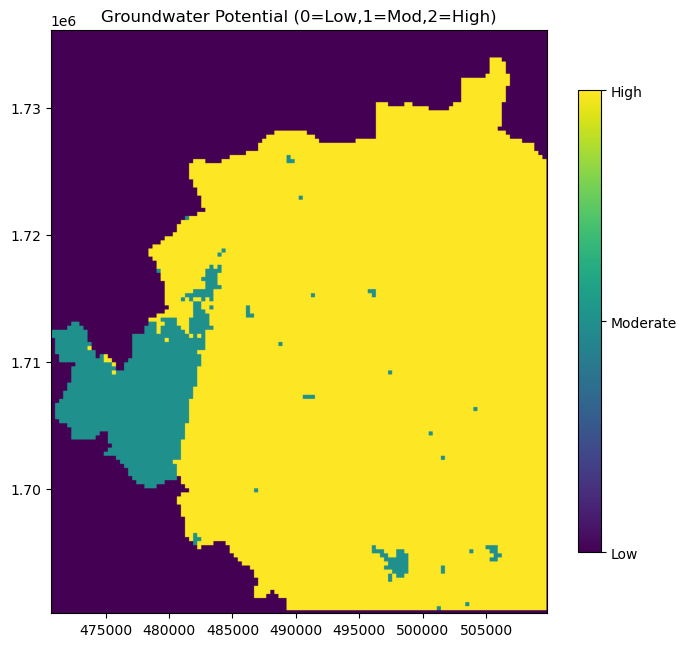

In [53]:
import matplotlib.pyplot as plt
from rasterio.plot import show
# read saved predicted GeoTIFF
with rasterio.open(out_tif) as src:
    arr = src.read(1)
    fig, ax = plt.subplots(figsize=(8,10))
    show(arr, transform=src.transform, ax=ax, cmap='viridis')
    ax.set_title("Groundwater Potential (0=Low,1=Mod,2=High)")
    # add colorbar, custom ticks
    cbar = plt.colorbar(ax.images[0], ax=ax, shrink=0.6)
    cbar.set_ticks([0,1,2])
    cbar.set_ticklabels(['Low','Moderate','High'])
    plt.show()


In [56]:
!pip install folium



   -------------------- ------------------- 1/2 [folium]
   ---------------------------------------- 2/2 [folium]



In [59]:
import folium
import matplotlib.pyplot as plt
import os
import numpy as np
from pyproj import Transformer

# ---------------------------------------------------------
# Configuration & Setup
# ---------------------------------------------------------
# Ensure we have the necessary data from previous steps
if 'src8' not in locals() or 'out_map' not in locals():
    raise SystemExit("Error: 'src8' (metadata) and 'out_map' (prediction) must be defined first.")

# Define output paths using your project directory
html_path = os.path.join(OUT_DIR, "dharwad_gwp_map.html")
png_filename = "gwp_overlay.png"
png_path = os.path.join(OUT_DIR, png_filename)

print("Generating interactive map...")

# ---------------------------------------------------------
# Step 1: Coordinate Conversion (UTM -> Lat/Lon)
# ---------------------------------------------------------
# Folium ONLY understands Latitude/Longitude (EPSG:4326).
# Your satellite image is likely in UTM (e.g., EPSG:32643).
# We must convert the image bounds to Lat/Lon for the map to work.

# Create a coordinate transformer
# src8.crs is the image projection, "EPSG:4326" is standard Lat/Lon
transformer = Transformer.from_crs(src8.crs, "EPSG:4326", always_xy=True)

# Get the bounds of your image (Left, Bottom, Right, Top)
left, bottom, right, top = src8.bounds

# Transform the corners to Lat/Lon
# Note: transformer.transform expects (x, y) -> (lon, lat)
lon_min, lat_min = transformer.transform(left, bottom)
lon_max, lat_max = transformer.transform(right, top)

# Calculate center for the map view
center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2

print(f"Map Center: {center_lat:.4f}, {center_lon:.4f}")

# ---------------------------------------------------------
# Step 2: Create the Map Base
# ---------------------------------------------------------
m = folium.Map(location=[center_lat, center_lon], zoom_start=11, control_scale=True)

# Add a satellite base layer (optional but looks nice)
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite',
    overlay=False,
    control=True
).add_to(m)

# ---------------------------------------------------------
# Step 3: Save Prediction as PNG
# ---------------------------------------------------------
# We save the numpy array 'out_map' as a clean PNG image
plt.figure(figsize=(8, 8))
# Use 'viridis' or 'RdYlGn' (Red-Yellow-Green) for GWP
plt.imshow(out_map, cmap='viridis') 
plt.axis('off')

# Save explicitly to the output folder
plt.savefig(png_path, bbox_inches='tight', pad_inches=0, transparent=True, dpi=150)
plt.close() # Close plot to free memory

# ---------------------------------------------------------
# Step 4: Overlay Image on Map
# ---------------------------------------------------------
# We use the Lat/Lon bounds calculated in Step 1
# Folium expects bounds in [[Lat_Min, Lon_Min], [Lat_Max, Lon_Max]] format
image_bounds = [[lat_min, lon_min], [lat_max, lon_max]]

folium.raster_layers.ImageOverlay(
    name='Groundwater Potential',
    # FIX: Use the full 'png_path' so Folium can find the file we just saved
    image=png_path,  
    bounds=image_bounds,
    opacity=0.6,
    interactive=True,
    cross_origin=False
).add_to(m)

# Add Layer Control to toggle the overlay
folium.LayerControl().add_to(m)

# ---------------------------------------------------------
# Step 5: Save and Display
# ---------------------------------------------------------
m.save(html_path)

print("-" * 30)
print(f"Interactive map saved to: {html_path}")
print(f"Overlay image saved to:   {png_path}")
print("Open the HTML file in your browser to view the map.")

Generating interactive map...
Map Center: 15.7835, 74.5798
------------------------------
Interactive map saved to: C:\Users\Suhas\Downloads\DATAAA\dharwad_gwp_map.html
Overlay image saved to:   C:\Users\Suhas\Downloads\DATAAA\gwp_overlay.png
Open the HTML file in your browser to view the map.


In [60]:
# Simple occlusion sensitivity for a sample patch
def occlusion_map(patch, model, target_class, occ_size=16):
    h,w,c = patch.shape
    base_prob = model.predict(patch[np.newaxis])[0,:,:, target_class].mean()
    sens = np.zeros((h,w))
    for i in range(0,h,occ_size):
        for j in range(0,w,occ_size):
            p_ = patch.copy()
            p_[i:i+occ_size, j:j+occ_size, :] = 0
            prob = model.predict(p_[np.newaxis])[0,:,:,target_class].mean()
            sens[i:i+occ_size, j:j+occ_size] = base_prob - prob
    return sens


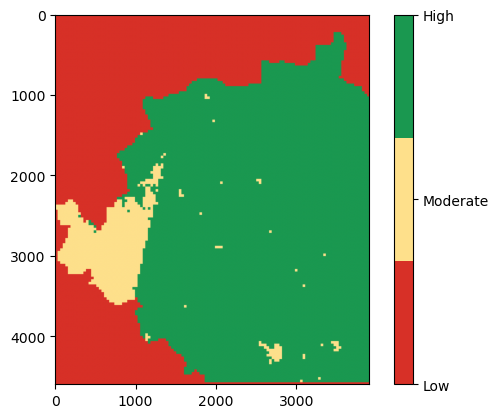

In [61]:
import matplotlib.colors as mcolors
cmap = mcolors.ListedColormap(['#d73027','#fee08b','#1a9850'])
plt.imshow(arr, cmap=cmap)
cbar = plt.colorbar(ticks=[0,1,2])
cbar.set_ticklabels(['Low','Moderate','High'])


In [63]:
from pptx import Presentation
from pptx.util import Inches
import os

# ---------------------------------------------------------
# Configuration
# ---------------------------------------------------------
# We use the same output directory as your other files
# If OUT_DIR is not defined in your session, we default to the current folder (".")
output_dir = OUT_DIR if 'OUT_DIR' in locals() else "."

img_filename = "gwp_overlay.png"
ppt_filename = "final_presentation.pptx"

# Construct full paths compatible with Windows
img_path = os.path.join(output_dir, img_filename)
ppt_path = os.path.join(output_dir, ppt_filename)

# ---------------------------------------------------------
# Verify Image Exists Before Creating PPT
# ---------------------------------------------------------
if not os.path.exists(img_path):
    print(f"❌ Error: Could not find image at: {img_path}")
    print("Please ensure you ran the 'Generate Map' step successfully.")
else:
    print(f"Found image at: {img_path}")
    print("Creating presentation...")

    # ---------------------------------------------------------
    # Create Presentation
    # ---------------------------------------------------------
    prs = Presentation()
    
    # Add a blank slide (Layout 5 is usually 'Title Only' or blank)
    slide = prs.slides.add_slide(prs.slide_layouts[5])
    
    # Add Title
    if slide.shapes.title:
        slide.shapes.title.text = "Deep Learning for Groundwater Potential - Dharwad"
    
    # Add Picture
    # We center it or place it nicely
    left = Inches(1)
    top = Inches(1.5)
    height = Inches(5)
    
    try:
        slide.shapes.add_picture(img_path, left, top, height=height)
        
        # Save the PPT
        prs.save(ppt_path)
        print("-" * 30)
        print(f"✅ Success! Presentation saved to: {ppt_path}")
    except Exception as e:
        print(f"An error occurred while adding the picture: {e}")

Found image at: C:\Users\Suhas\Downloads\DATAAA\gwp_overlay.png
Creating presentation...
------------------------------
✅ Success! Presentation saved to: C:\Users\Suhas\Downloads\DATAAA\final_presentation.pptx
